In [ ]:
#hide
#all_slow

# Segmentation Pytorch FPN-ResNet34

> Pytorch solution from Kaggle template.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marcomatteo/steel_segmentation/blob/master/nbs/13_torch.seg_fpn_resnet34.ipynb)

This notebook uses a FPN backbone model with pretrained resnet34 encoder, with simple augmentations using albumentations library, uses BCE loss, metrics like Dice and IoU. The segmentation model is from [segmentation_models.pytorch](https://github.com/qubvel/segmentation_models.pytorch) which comes with a lot pre-implemented segmentation architectures. 

The kaggle template from which I've borrowed this code is: https://www.kaggle.com/rishabhiitbhu/unet-pytorch-inference-kernel.

In [1]:
#hide 
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from steel_segmentation.all import *
from fastai.vision.all import *

import warnings
import random
import os
import cv2
from tqdm import tqdm
import pandas as pd
import numpy as np
from functools import partial

from matplotlib import pyplot as plt

import torch
import torch.backends.cudnn as cudnn
from torch import optim
import torch.utils.data as data
import albumentations as alb

import segmentation_models_pytorch as smp

seed_everything()

In [3]:
torch.device("cuda:0").type

'cuda'

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.cuda.empty_cache()

In [6]:
!nvidia-smi

Wed Apr 14 20:36:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro M4000        On   | 00000000:00:05.0 Off |                  N/A |
| 46%   31C    P8    11W / 120W |      4MiB /  8126MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
print_competition_data(models_dir)

../models/fastai-UNET-ResNet34-256-stage5.pth
../models/resnet18_class.pth
../models/resnet18-DynamicUNET-stage0.pth
../models/fastai-UNET-XResNeXt34-128x800.pth
../models/fastai-UNET-XResNeXt34-128x800-finetuning.pth
../models/.ipynb_checkpoints
../models/ResNet18-stage1-f1_0918.pth
../models/kaggle-UNET-ResNet34.pth
../models/ResNet18-encoder.pt
../models/logs
../models/kaggle-FPN-ResNet34.pth
../models/resnet18-DynamicUNET-stage1.pth


## Model creation

In [8]:
model = smp.FPN("resnet34", encoder_weights='imagenet', classes=4, activation=None)

In [9]:
loaded_dict = torch.load(models_dir/"kaggle-FPN-ResNet34.pth")
model.load_state_dict(loaded_dict["state_dict"], strict=True)

<All keys matched successfully>

## Alternative training with FastAi

In [10]:
bs = 8

In [11]:
cond = train_pivot[0] != -1 # no common hard negatives
df = train_pivot.loc[cond]
df.shape

(6666, 6)

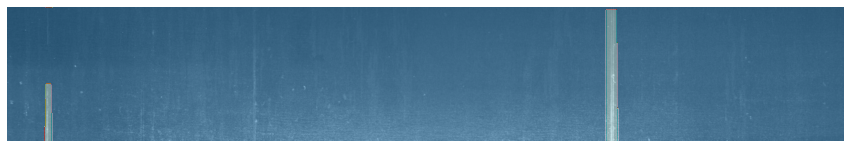

In [13]:
block = DataBlock(blocks = (ImageBlock,SteelMaskBlock(codes=[1,2,3,4],flatten_mask=False)),
                  get_x = ReadImagePathFromIndex,
                  get_y = ReadRLEs(cols=[1,2,3,4]),
                  splitter = TrainTestSplitter(test_size=0.2),
                  batch_tfms=[Normalize.from_stats(*imagenet_stats)])

ds = block.datasets(df)

img, mask = ds[1]
ax = img.show(figsize=(15,5))
mask.show(ctx=ax);

In [14]:
dls = block.dataloaders(source=df, bs=bs, device=torch.device("cuda:0"))

In [20]:
#model

In [21]:
def splitter(m): return convert_params([[m.encoder], [m.decoder], [m.segmentation_head]])

In [22]:
def opt_func(params, **kwargs): return OptimWrapper(params, torch.optim.Adam, **kwargs)

In [23]:
learn = Learner(dls=dls, model=model, 
                loss_func=BCEWithLogitsLossFlat(), 
                opt_func=opt_func,
                cbs=[CudaCallback(), ShowGraphCallback()], 
                model_dir=models_dir, 
                metrics=[ModDiceMulti(), KaggleDice()], 
                splitter=splitter).to_fp16()

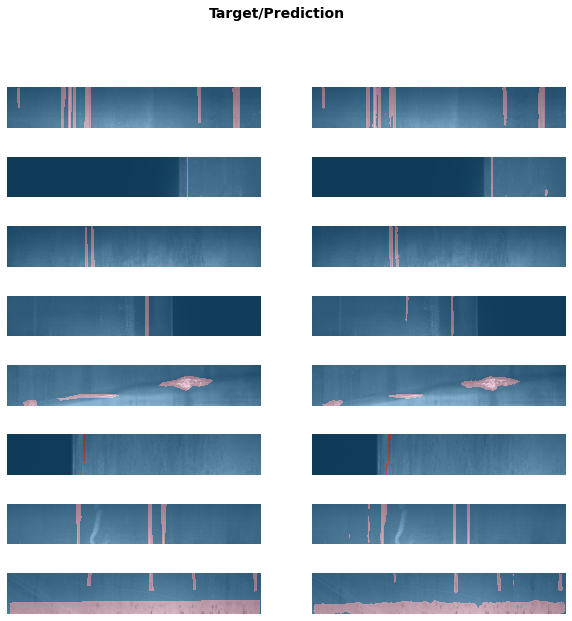

In [25]:
learn.show_results(figsize=(10,10))

In [26]:
learn.validate()

(#3) [0.012086167931556702,0.13157743945314376,0.2558978303538453]

## Pytorch training

Training FPN:

In [ ]:
model_trainer.start()

Starting epoch: 0 | phase: train | ⏰: 13:55:19
Loss: 0.0242 | IoU: 0.2544 | dice: 0.5642 | dice_neg: 0.8215 | dice_pos: 0.3338
Starting epoch: 0 | phase: val | ⏰: 14:06:21
Loss: 0.0168 | IoU: 0.3528 | dice: 0.6079 | dice_neg: 0.7812 | dice_pos: 0.4612
******** New optimal found, saving state ********

Starting epoch: 1 | phase: train | ⏰: 14:08:38
Loss: 0.0147 | IoU: 0.3673 | dice: 0.6472 | dice_neg: 0.8425 | dice_pos: 0.4722
Starting epoch: 1 | phase: val | ⏰: 14:19:29
Loss: 0.0177 | IoU: 0.3094 | dice: 0.6462 | dice_neg: 0.9245 | dice_pos: 0.4108

Starting epoch: 2 | phase: train | ⏰: 14:21:19
Loss: 0.0144 | IoU: 0.3834 | dice: 0.6518 | dice_neg: 0.8307 | dice_pos: 0.4915
Starting epoch: 2 | phase: val | ⏰: 14:32:09
Loss: 0.0121 | IoU: 0.4191 | dice: 0.6985 | dice_neg: 0.9045 | dice_pos: 0.5243
******** New optimal found, saving state ********

Starting epoch: 3 | phase: train | ⏰: 14:34:17
Loss: 0.0120 | IoU: 0.4361 | dice: 0.6992 | dice_neg: 0.8638 | dice_pos: 0.5518
Starting epoch

## Results

Training on FPN:

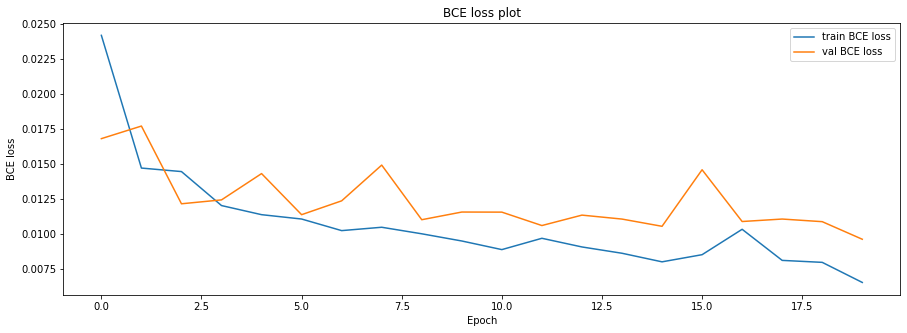

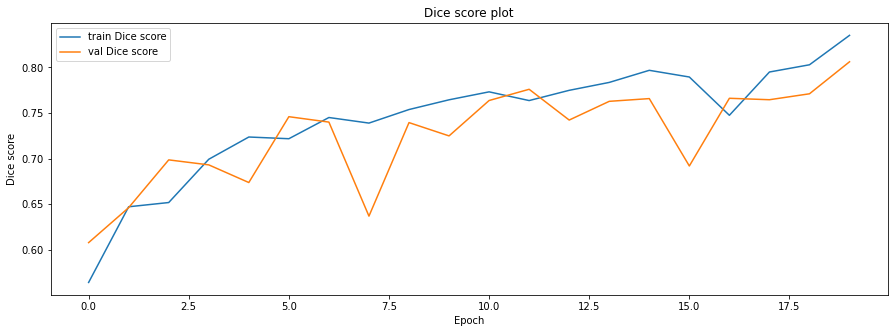

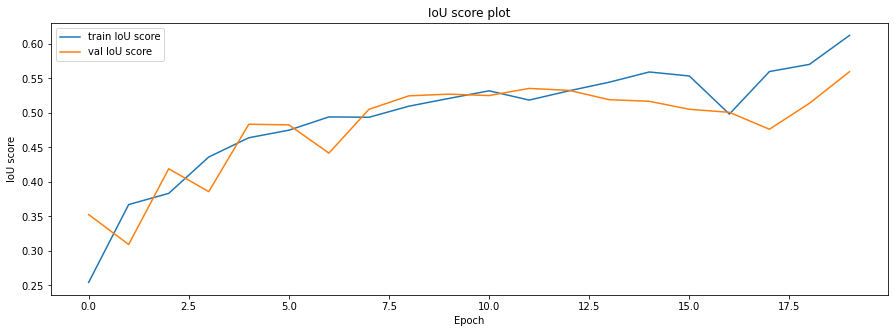

In [ ]:
# PLOT TRAINING
losses = model_trainer.losses
dice_scores = model_trainer.dice_scores  # overall dice
iou_scores = model_trainer.iou_scores


def plot(scores, name):
    plt.figure(figsize=(15, 5))
    plt.plot(range(len(scores["train"])),
             scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot')
    plt.xlabel('Epoch')
    plt.ylabel(f'{name}')
    plt.legend()
    plt.show()


plot(losses, "BCE loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")

## Inference

In [ ]:
def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((256, 1600), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [ ]:
sample_submission_path = path / 'sample_submission.csv' # file da cui pescare i ImageId
test_data_folder = path / "test_images" # cartella dove trovare le immagini

In [ ]:
testset = get_test_dls(sample_submission_path)

In [ ]:
# Initialize mode and load trained weights
ckpt_path = models_dir/"kaggle-FPN-ResNet34.pth"
device = torch.device("cuda")
model = smp.FPN("resnet34", encoder_weights='imagenet', classes=4, activation=None)
model.to(device)
model.eval()
state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])

<All keys matched successfully>

In [ ]:
best_threshold = 0.5
min_size = 3000

In [ ]:
# start prediction
predictions = []
for i, batch in enumerate(tqdm(testset)):
    fnames, images = batch
    batch_preds = torch.sigmoid(model(images.to(device)))
    batch_preds = batch_preds.detach().cpu().numpy()
    
    for fname, preds in zip(fnames, batch_preds):
        for cls, pred in enumerate(preds):
            pred, num = post_process(pred, best_threshold, min_size)
            rle = mask2rle(pred)
            name = fname + f"_{cls+1}"
            predictions.append([name, rle])

# save predictions to submission.csv
df = pd.DataFrame(predictions, columns=['ImageId_ClassId', 'EncodedPixels'])
df.to_csv("FPN_submission.csv", index=False)

100%|██████████| 1377/1377 [02:19<00:00,  9.89it/s]


In [ ]:
df.head()

,ImageId_ClassId,EncodedPixels
0,0000f269f.jpg_1,
1,0000f269f.jpg_2,
2,0000f269f.jpg_3,146576 55 146637 47 146694 19 146715 230 146947 254 147202 4095 151299 254 151557 252 151817 248 152157 53 152230 39 152293 24
3,0000f269f.jpg_4,
4,000ccc2ac.jpg_1,
